# [CDAF] Atividade 4

## Nome e matrícula
Nome: Luís Felipe Ramos Ferreira
Matrícula: 2019022553

## Referências
- [1] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- [2] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.ExpectedThreat.html#socceraction.xthreat.ExpectedThreat
- [3] https://socceraction.readthedocs.io/en/latest/api/generated/socceraction.xthreat.get_successful_move_actions.html#socceraction.xthreat.get_successful_move_actions
- [4] https://socceraction.readthedocs.io/en/latest/documentation/valuing_actions/xT.html

In [1]:
# Importando bibliotecas
from tqdm import tqdm
import numpy as np
import pandas as pd
import socceraction.spadl as spd
from socceraction import xthreat as xt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

### Premier League  p/ SPADL com pré-processamentos

In [2]:
# carregando os eventos
# neste caso, usaremos a mesma base de dados da atv03
path: str = "../data/atv03/events/events_England.json"
events: pd.DataFrame = pd.read_json(path_or_buf=path)

In [3]:
# pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                                'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
events['milliseconds'] = events['eventSec'] * 1000
events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

In [4]:
# carregando as partidas, pois vamos saber quais times jogam em casa e fora p/ usar como parametro do SPADL
path: str = "../data/atv03/matches/matches_England.json"
matches: pd.DataFrame = pd.read_json(path_or_buf=path)

In [5]:
# as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
team_matches: list = []
for i in tqdm(range(len(matches))):
    match = pd.DataFrame(matches.loc[i, "teamsData"]).T
    match["matchId"] = matches.loc[i, "wyId"]
    team_matches.append(match)
team_matches = pd.concat(team_matches).reset_index(drop=True)

100%|██████████| 380/380 [00:00<00:00, 2462.67it/s]


In [6]:
# fazendo a conversão p/ SPADL, padronizando a direção de jogo da esquerda p/ a direita e adicionando os nomes dos tipos de ações
spadl: list = []
game_ids: list = events.game_id.unique().tolist()
for g in tqdm(game_ids):
    match_events = events.loc[events.game_id == g]
    match_home_id = team_matches.loc[(team_matches.matchId == g) & (team_matches.side == 'home'), 'teamId'].values[0]
    match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
    match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
    match_actions = spd.add_names(match_actions)
    spadl.append(match_actions)
spadl = pd.concat(spadl).reset_index(drop=True)

100%|██████████| 380/380 [01:33<00:00,  4.07it/s]


In [7]:
# adicionando o nome dos jogadores
path: str = "../data/atv03/players/players.json"
players: pd.DataFrame = pd.read_json(path_or_buf=path)
players["player_name"] = players["shortName"]
players = players[["wyId", "player_name"]].rename(columns={"wyId": "player_id"})
spadl = spadl.merge(players, on="player_id", how="left")
spadl.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2499719,1,2.758649,1609,25413,51.45,34.68,32.55,14.96,177959171,0,0,1,0,pass,success,foot,A. Lacazette
1,2499719,1,4.946850,1609,370224,32.55,14.96,53.55,17.00,177959172,0,0,1,1,pass,success,foot,R. Holding
2,2499719,1,6.542188,1609,3319,53.55,17.00,36.75,19.72,177959173,1,0,1,2,pass,success,head,M. \u00d6zil
3,2499719,1,8.143395,1609,120339,36.75,19.72,43.05,3.40,177959174,1,0,1,3,pass,success,head,Mohamed Elneny
4,2499719,1,10.302366,1609,167145,43.05,3.40,75.60,8.16,177959175,0,0,1,4,pass,success,foot,Beller\u00edn


## Questão 1
- Crei um dataframe "shots" à partir do dataframe "spadl", contendo apenas os chutes.
- Crie 4 colunas no dataframe "shots" a serem usadas como features de um modelo de xG.
- Justifique a escolha das features.

In [8]:
GOAL_CENTER_X: int = 105
GOAL_CENTER_Y: int = 34

UPPER_CROSSBAR_X: int = 105
UPPER_CROSSBAR_Y: int = 38

LOWER_CROSSBAR_X: int = 105
LOWER_CROSSBAR_Y: int = 30

In [9]:
shots: pd.DataFrame = spadl.query('type_name == "shot"').copy()

shots["distance_to_goal"] = np.sqrt((shots["start_x"] - GOAL_CENTER_X) ** 2 + (shots["start_y"] - GOAL_CENTER_Y) ** 2)

def get_shot_angle(shot_pos_x: np.float_, shot_pos_y: np.float_) -> np.float_:
    v1: np.array = np.array([UPPER_CROSSBAR_X - shot_pos_x, UPPER_CROSSBAR_Y - shot_pos_y])
    v2: np.array = np.array([LOWER_CROSSBAR_X - shot_pos_x, LOWER_CROSSBAR_Y - shot_pos_y])
    return np.arccos(np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2)))
    
shots["angle_of_shot"] = shots[["start_x", "start_y"]].apply(lambda pos: get_shot_angle(pos["start_x"], pos["start_y"]), axis=1)
shots["squared_distance_to_goal"] = shots["distance_to_goal"] ** 2
shots["bodypart_capacity_of_scoring"] = shots["bodypart_name"].apply(lambda x: 1 if x == "foot" else .125)
shots

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,result_id,action_id,type_name,result_name,bodypart_name,player_name,distance_to_goal,angle_of_shot,squared_distance_to_goal,bodypart_capacity_of_scoring
34,2499719,1,94.595788,1609,25413,92.40,40.12,105.0,37.4,177959212,...,1,34,shot,success,foot,A. Lacazette,14.007655,0.509981,196.2144,1.000
40,2499719,1,179.854785,1631,26150,89.25,32.64,105.0,40.8,177959247,...,0,40,shot,fail,foot,R. Mahrez,15.808608,0.494098,249.9121,1.000
60,2499719,1,254.745027,1631,14763,100.80,32.64,105.0,34.0,177959280,...,1,60,shot,success,head/other,S. Okazaki,4.414703,1.467310,19.4896,0.125
87,2499719,1,425.824035,1609,7868,85.05,45.56,105.0,40.8,177959289,...,0,87,shot,fail,foot,A. Oxlade-Chamberlain,23.057235,0.300168,531.6361,1.000
175,2499719,1,815.462015,1609,7868,78.75,47.60,105.0,37.4,177959429,...,0,175,shot,fail,foot,A. Oxlade-Chamberlain,29.563872,0.240030,874.0225,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482739,2500098,2,1972.969422,1633,8561,75.60,37.40,105.0,40.8,251596053,...,0,982,shot,fail,foot,M. Noble,29.595946,0.266984,875.9200,1.000
482799,2500098,2,2193.887080,1633,41174,90.30,45.56,105.0,30.6,251596096,...,1,1042,shot,success,foot,M. Lanzini,18.700898,0.338800,349.7236,1.000
482824,2500098,2,2377.197700,1623,7879,92.40,25.84,105.0,34.0,251596357,...,0,1067,shot,fail,foot,T. Walcott,15.011516,0.448739,225.3456,1.000
482826,2500098,2,2381.481625,1623,145692,96.60,42.16,105.0,30.6,251596359,...,0,1069,shot,fail,foot,O. Niasse,11.710918,0.506448,137.1456,1.000


- Distância até o gol: para essa métrica, considera-se a posição de chute como sendo as posições iniciais das coordenadas x e y do evento de chute, e a posição do gol como sendo as coordenadas (105, 34), exatamente ao centro do gol. A distância entre a bola e o gol no momento do chute é uma das *features* mais óbvias a se pensar quando o assunto 'um modelo de *expected goals*. De maneira simples podemos analisar e notar que chutes de longas distância, de uma forma geral, possuem uma menor probabilidade de resultarem em gol, assim como é análogo o caso de chutes a curta distância.

- Ângulo de chute: para essa métrica, considera-se a posição de chute como sendo as posições iniciais das coordenadas x e y do evento de chute, e a posição das traves do gol como sendo as coordenadas (105, 38) para a trave "de cima" e (105, 30) para a trave "de baixo". Dessa forma, considera-se que o ângulo de chute é o ângulo entre os vetores formados por esses três pontos, onde a  posição da bola seria o ponto de origem. Assim como a distância entre a bola e o gol, o ângulo de chute também é uma das *features* mais óbvias a se pensar ao considerar um modelo de *expected goals*. Chutes que "enxergam" uma grande área do gol comumente possuem maior probabilidade de resultarem em gol, enquanto chutes em posições muito extremas, que significam um baixo ângulo de visão do gol, resultam raramente em sucesso.

- Distância quadrado até o gol: essa *feature* é simplesmente a primeira *feature* de distância do chute até o gol, mas adicionada como um termo quadrático e não linear. Isso é feito para que a distância de chute até o gol tenha um impacto maior na qualidade das predições, aumentando principalmente a qualidade das predições de chutes que estejam a uma cureta distância do gol (algo em torno de 6 metros ou menos). Tal *feature* é mais bem discutida e detalhada no seguinte artigo: https://towardsdatascience.com/modeling-expected-goals-a756baa2e1db.

- Capacidade de parte do corpo em marcar gols: por fim, considera-se a quarta *feature* do modelo como sendo a parte do corpo com a qual o chute foi realizado. Após uma análise rápida dos dados de entrada, nota-se que chutes com o pé são aproximadamente 8 vezes mais frequentes do que chutes com outras partes do corpo, e essa proporção se mantém para o subconjunto de chutes que resultam em sucesso. Dessa forma, foi atribuido um valor de 1 para essa *feature* quando os chutes foram feitos com o pé, e 0.125 caso contrário.

## Questão 2
- Crie uma coluna numérica binária "goal" no dataframe "shots" indicando se o chute resultou em gol ou não.
- Use regressão logística [1] p/ treinar (.fit(X_train, y_train)) um modelo de xG usando as features criadas na questão 1.
- Use 70% dos dados para treino e 30% para teste.
- Reporte a acurácia do modelo para os conjuntos de treino (.score(X_train, y_train)) e teste (.score(X_test, y_test)).

In [10]:
shots["goal"] = shots["result_name"].apply(lambda res: int(res == "success"))
shots.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(shots[["distance_to_goal", "angle_of_shot", "squared_distance_to_goal", "bodypart_capacity_of_scoring"]].to_numpy(), shots["goal"].to_numpy(), test_size=0.3, random_state=0)
clf = LogisticRegression(random_state=0, max_iter=1_000)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Acurácia para conjunto de treino: {clf.score(X_train, y_train)}")
print(f"Acurácia para conjunto de teste: {clf.score(X_test, y_test)}")

Acurácia para conjunto de treino: 0.8970414201183432
Acurácia para conjunto de teste: 0.8919132149901381


Os valores de acurácia requeridos pelo enunciado estão citados acima e, a princípio, podem parecer otimistas. No entanto, devemos analisar outras features para que possa-se fazer uma boa afirmação sobre a qualidade do modelo. Uma das métricas não requeridas mas que poderia ser analisada é o *f1_score* que, no modelo construído, não possuía um valor interessante. Na célula abaixo podemos ver tanto este valor de *f1_score* calculado como a matriz de confusão mostrando as comparações entre as classes que foram previstas e as classes verdadeiras. Podemos ver claramente que um modelo cometeu muitos erros ao classificar 257 chutes que não foram gols como gols. Esses valores desanimadores podem ter sido gerados por diversos fatores, como um baixo número de dados de treino, baixa capacidade do modelo e também a falta de informações importantes como dados de *tracking*.

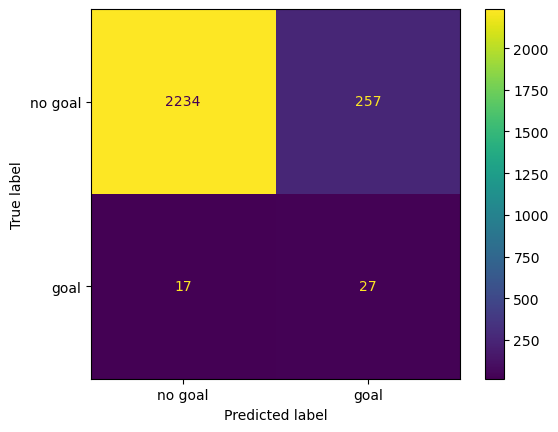

In [11]:
confusion_matrix: np.array = metrics.confusion_matrix(clf.predict(X_test), y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["no goal", "goal"])
cm_display.plot()

## Questão 3
- Use o modelo treinado na questão 2 p/ prever a probabilidade de gol de todos os chutes do dataframe "shots". Reporte essas probabilidades no dataframe "shots" em uma coluna "xG".
- Agrupe o dataframe "shots" por "player_name" e reporte a soma dos "goal" e "xG".
- Reporte os 10 jogadores com maior xG.
- Reporte os 10 jogadores com maior diferença de Gols e xG.

In [12]:
shots["xG"] = shots[["distance_to_goal", "angle_of_shot", "squared_distance_to_goal", "bodypart_capacity_of_scoring"]].apply(lambda x: clf.predict_proba([[x["distance_to_goal"], x["angle_of_shot"], x["squared_distance_to_goal"], x["bodypart_capacity_of_scoring"]]])[0][1], axis=1)
xG_goal_sum: pd.DataFrame = shots.groupby(by="player_name")[["goal", "xG"]].sum().copy()
xG_goal_sum["goal_xG_diff"] = xG_goal_sum["goal"] - xG_goal_sum["xG"]
xG_goal_sum.head()

,goal,xG,goal_xG_diff
player_name,,,
A. Ayew,3,3.921104,-0.921104
A. Barnes,9,6.730241,2.269759
A. Carrillo,1,2.028618,-1.028618
A. Carroll,3,2.786681,0.213319
A. Christensen,0,1.295628,-1.295628


In [13]:
from IPython.display import display_html

largest_xG: pd.DataFrame = xG_goal_sum.nlargest(n=10, columns=["xG"])
largest_goal_xG_diff: pd.DataFrame = xG_goal_sum.nlargest(n=10, columns=["goal_xG_diff"])
largest_xG_goal_diff: pd.DataFrame = xG_goal_sum.nsmallest(n=10, columns=["goal_xG_diff"])

largest_xG = largest_xG.style.set_table_attributes("style='display:inline'").set_caption("10 jogadores com maior xG")
largest_goal_xG_diff = largest_goal_xG_diff.style.set_table_attributes("style='display:inline'").set_caption("10 jogadores com maior diferença entre gols e xG")
smallest_goal_xG_diff = largest_xG_goal_diff.style.set_table_attributes("style='display:inline'").set_caption("10 jogadores com menor diferença entre gols e xG")

display_html(largest_xG._repr_html_() + largest_goal_xG_diff._repr_html_() + smallest_goal_xG_diff._repr_html_(), raw=True)


,goal,xG,goal_xG_diff
player_name,,,
H. Kane,27,22.107838,4.892162
Mohamed Salah,31,17.347098,13.652902
R. Sterling,17,14.198995,2.801005
R. Lukaku,16,13.441310,2.558690
S. Ag\u00fcero,17,13.063621,3.936379
Richarlison,5,10.550726,-5.550726
M. Arnautovi\u0107,11,10.476770,0.523230
Gabriel Jesus,13,10.356049,2.643951
\u00c1lvaro Morata,11,10.351903,0.648097


Os 10 jogadores com maior *xG* calculados são atacantes dos principais clubes da Premier League, o que era esperado, já que atacantes costumam chutar muito mais ao gol adversário do que o restante da equipe, além de que tais chutes comumente são de posições favoráveis à marcação do gol. Mohamed Salah, o segundo colocado, foi o artilheiro do campeonato inglês na temporada 17/18 com 31 gols marcados, portanto não é surpresa alguma sua colocação na classificação gerada. O líder Harry Kane, por sua vez, é um grande centroavante, conhecido por ser um grande finalizador, portanto sua posição na liderança também não é nenhuma surpresa, fora o fato de que na temporada em questão ele foi o vice-artilheiro, com 27 gols marcados.

Em relação aos jogadores com as 10 maiores diferenças entre o número de gols marcados e o *xG* calculado, podemos ver Mohamed Salah como o líder. Sua métrica de *xG* foi bem abaixo do real número de gols que ele marcou, o que pode ser interpretado como um ponto de qualidade de finalização do atleta egípcio, que converteu com boa frequência suas oportunidades de chute, mesmo que estas fossem em situações de baixa probabilidade de gol. Os outros jogadores listados também são atacantes dos principais clubes, o que demonstra a qualidade dos atletas nessas posições em aproveitar oprtunidades de marcar gols.

Uma outra informação coletada foram os 10 jogadores com os menores valores de diferença entre o número de gols marcados e o *xG* calculado. Jogadores nessa lista podem ser vistos como aqueles que não aproveitaram suas chances de chutes e não conseguiram converter em gols boas oportunidades. O líder dessa vez é Christian Benteke, centroavante do Crystal Palace. A métrica computada de *xG* previu aproximadamente 8.7 gols para o alteta no decorrer doc ampeonato, mas apenas dois foram marcados, mostrando uma certa limitação do atleta em converter suas chances de gol.

## Questão 4 [4]
- Instancie um objeto ExpectedThreat [2] com parâmetros l=25 e w=16.
- Faça o fit do modelo ExpectedThreat com o dataframe "spadl".

In [17]:
xT = xt.ExpectedThreat()
xT.fit(actions=spadl)

# iterations:  29


## Questão 5
- Crie um dataframe "prog_actions" à partir do dataframe "spadl", contendo apenas as ações de progressão e que são bem-sucedidas [3].
- Use o método rate do objeto ExpectedThreat p/ calcular o valor de cada ação de progressão do dataframe "prog_actions", em uma coluna chamada "action_value".
- Agrupe o dataframe "prog_actions" por "player_name" e reporte a soma dos "action_value".
- Reporte os 10 jogadores com maior "action_value".

In [18]:
prog_actions: pd.DataFrame = xt.get_successful_move_actions(spadl)
prog_actions["action_value"] = xT.rate(actions=prog_actions)
aux: pd.DataFrame = prog_actions.groupby(by="player_name", as_index=False)["action_value"].sum()
aux.head()

,player_name,action_value
0,A. Ayew,0.650209
1,A. Barnes,0.476319
2,A. Begovi\u0107,1.076615
3,A. Carrillo,2.295035
4,A. Carroll,0.228918


In [19]:
aux.nlargest(n=10, columns=["action_value"])

,player_name,action_value
270,K. De Bruyne,13.070566
33,A. S\u00e1nchez,9.623274
50,Azpilicueta,9.266392
165,F\u00e0bregas,8.462973
43,A. Young,7.747678
353,M. \u00d6zil,7.641888
146,E. Hazard,7.286040
81,C. Eriksen,6.875025
393,P. Pogba,6.631376
440,S. Francis,6.603875


Os 10 jogadores com maior *action_value* apresentados são aqueles que mais contribuíram para a criação de jogadas perigosas na temporada 17/18 na Inglaterra.

Alguns nomes não são nem um pouco surpreendentes, como o de Kevin de Bruyne na liderança. O meio-campista do Manchester City é um grande jogador e que possui uma capacidade ofensiva e de criação de boas jogadas extremamente alta. Outros nomes como os de Paul Pogba e Christian Eriksen também são esperados, dados os mesmos motivos supracitados.